### Imports

In [96]:
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

### Data Analysis & Cleaning

In [97]:
risk_df = pd.read_csv('maternal_health_risk_data.csv', index_col=False)
risk_df['RiskLevel']=risk_df['RiskLevel'].replace('high risk', 2)
risk_df['RiskLevel']=risk_df['RiskLevel'].replace('mid risk', 1)
risk_df['RiskLevel']=risk_df['RiskLevel'].replace('low risk', 0)
risk_df.head()

C:\Users\domin\AppData\Local\Temp\ipykernel_17148\746776428.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  risk_df['RiskLevel']=risk_df['RiskLevel'].replace('low risk', 0)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


Text(0, 0.5, 'Diastolic BP')

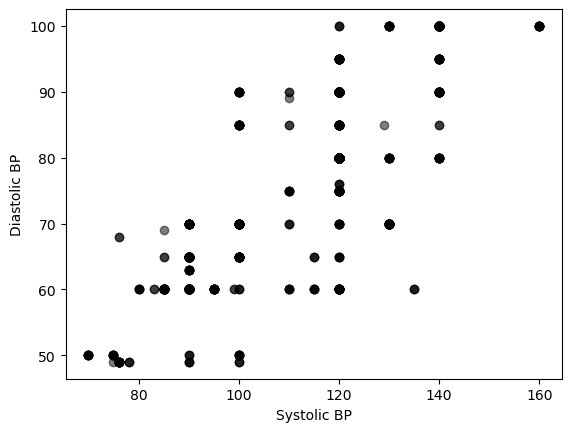

In [98]:
#check systolic and diastolic relationship
X = risk_df['SystolicBP']
y = risk_df['DiastolicBP']
plt.scatter(X,y, alpha=0.5, color='black')
plt.xlabel('Systolic BP')
plt.ylabel('Diastolic BP')

<Axes: xlabel='RiskLevel', ylabel='count'>

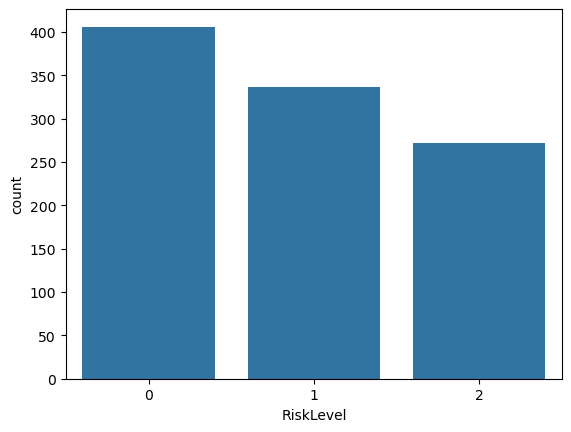

In [99]:
sns.countplot(x='RiskLevel',data=risk_df)

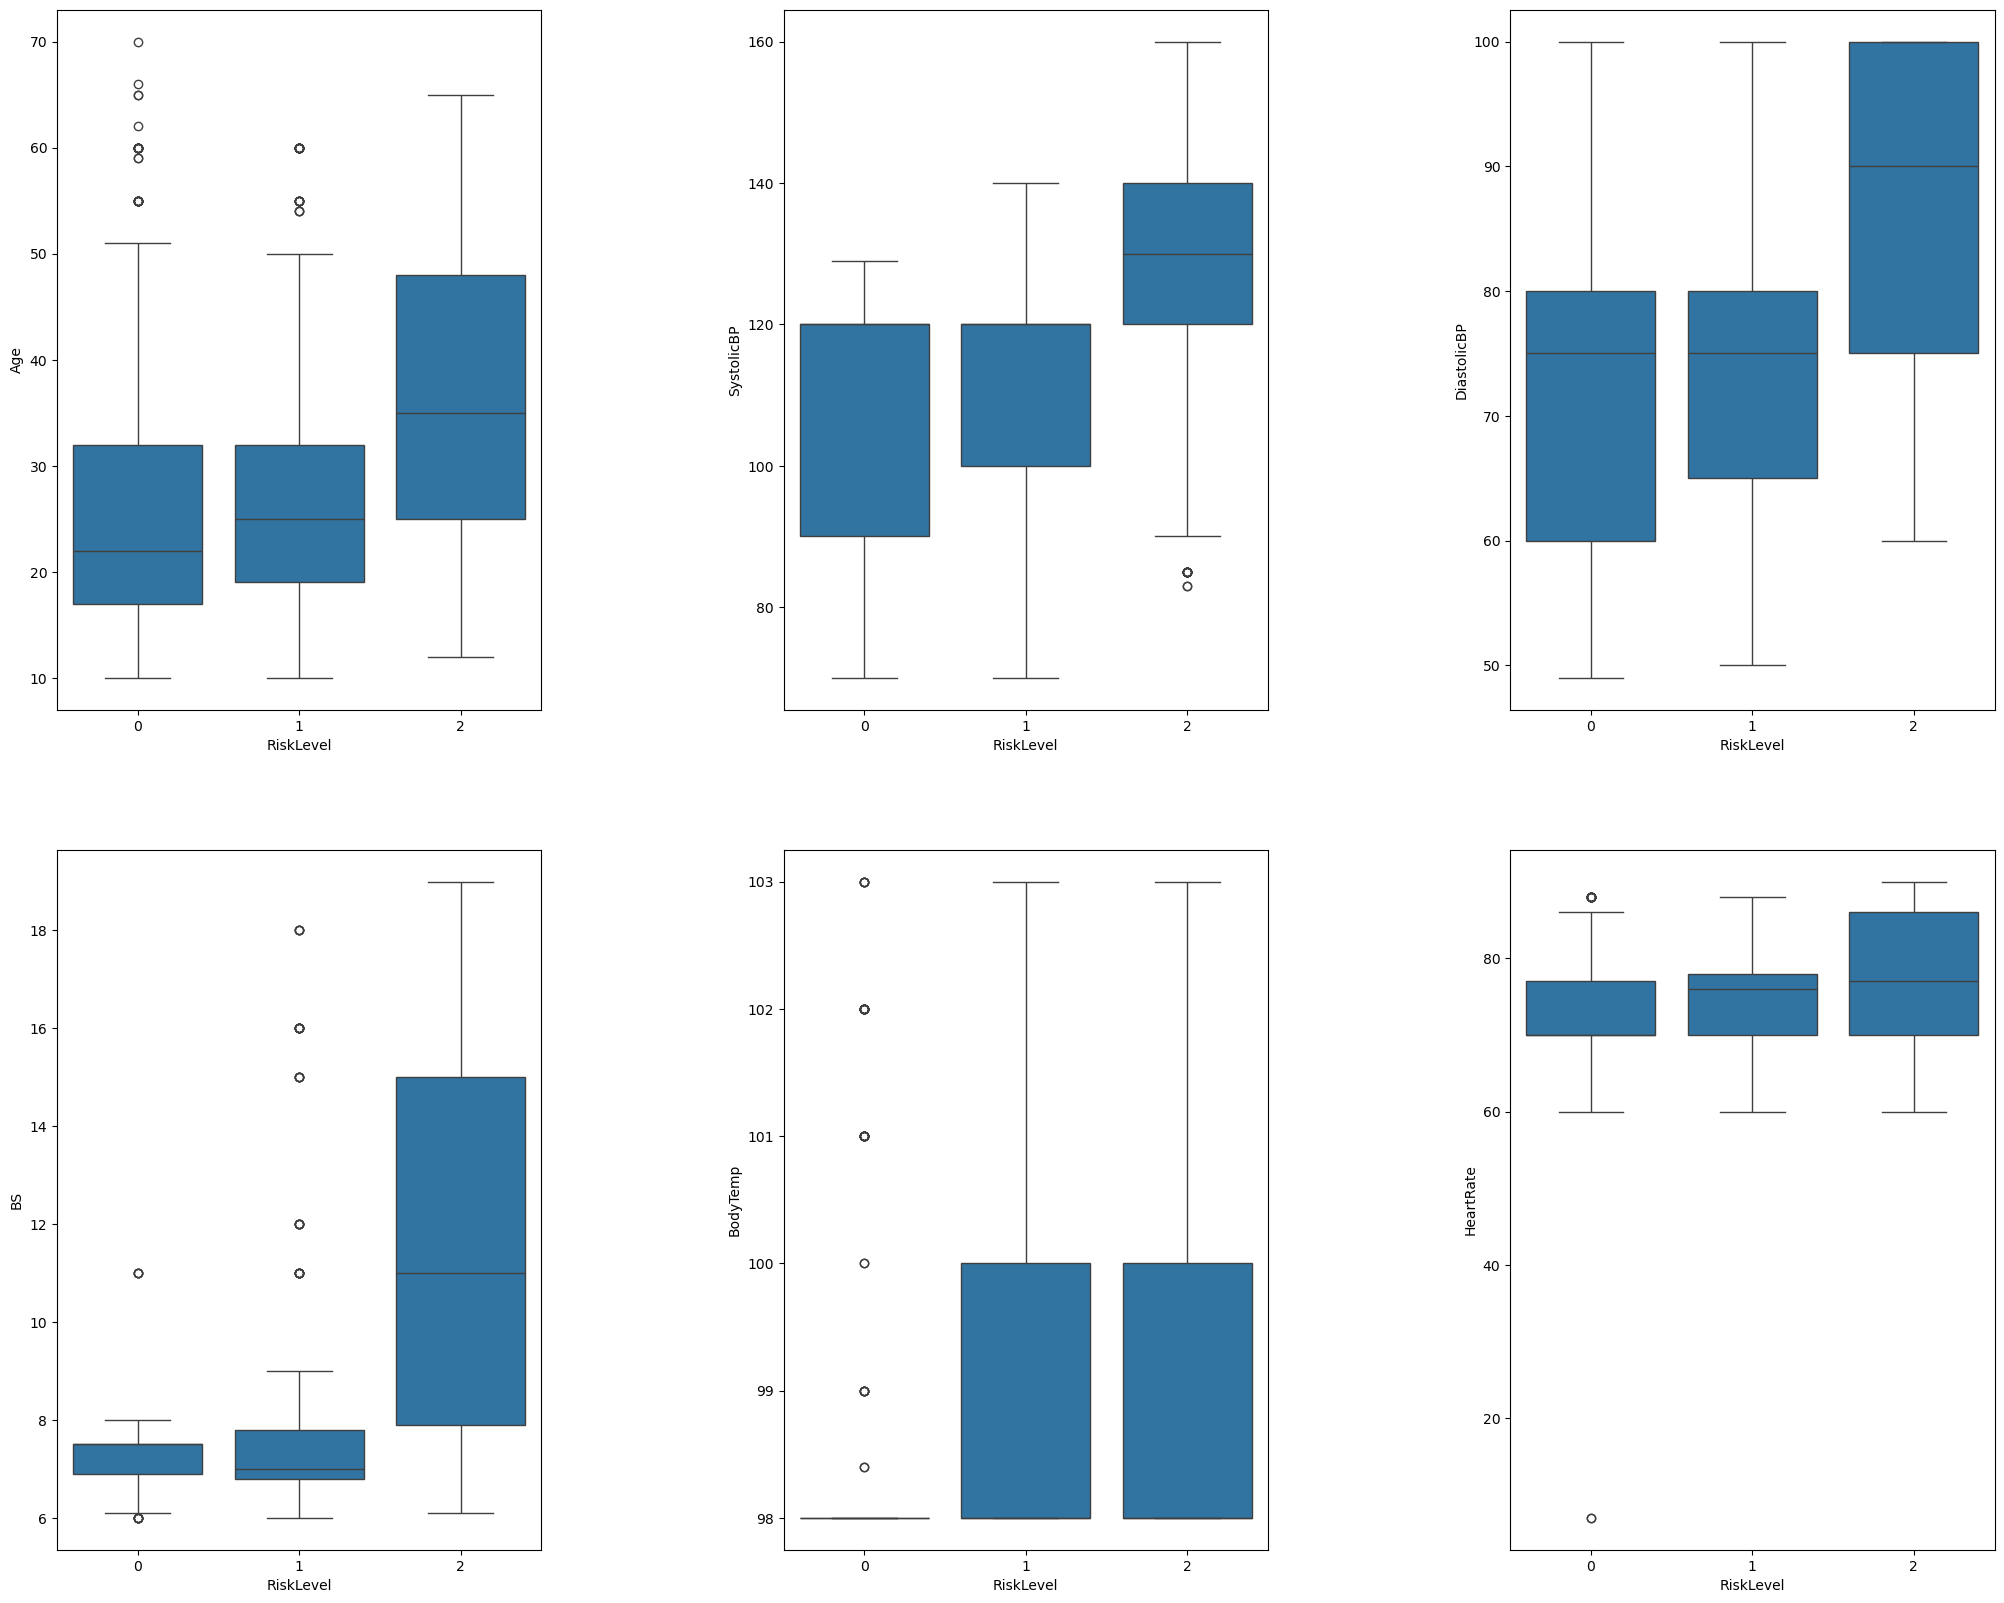

In [100]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(25,20))
fig.subplots_adjust(hspace=.2, wspace=.5)
axes= axes.ravel() 
for i, col in enumerate(risk_df.columns[:-1]): 
    _ = sns.boxplot(y=col, x='RiskLevel', data=risk_df, ax=axes[i]) 


In [101]:
risk_df.describe()
#outliers
data = risk_df.describe()
HR_IQR = data['HeartRate']['75%']-data['HeartRate']['25%']
HR_UQ = data['HeartRate']['75%']+1.5*HR_IQR
HR_LQ = data['HeartRate']['25%']-1.5*HR_IQR
HR_outliers = risk_df[(risk_df['HeartRate']<HR_LQ)|(risk_df['HeartRate']>HR_UQ)]
HR_outliers
risk_df_dropHR = risk_df.drop(risk_df[(risk_df['HeartRate']<HR_LQ)|(risk_df['HeartRate']>HR_UQ)].index)

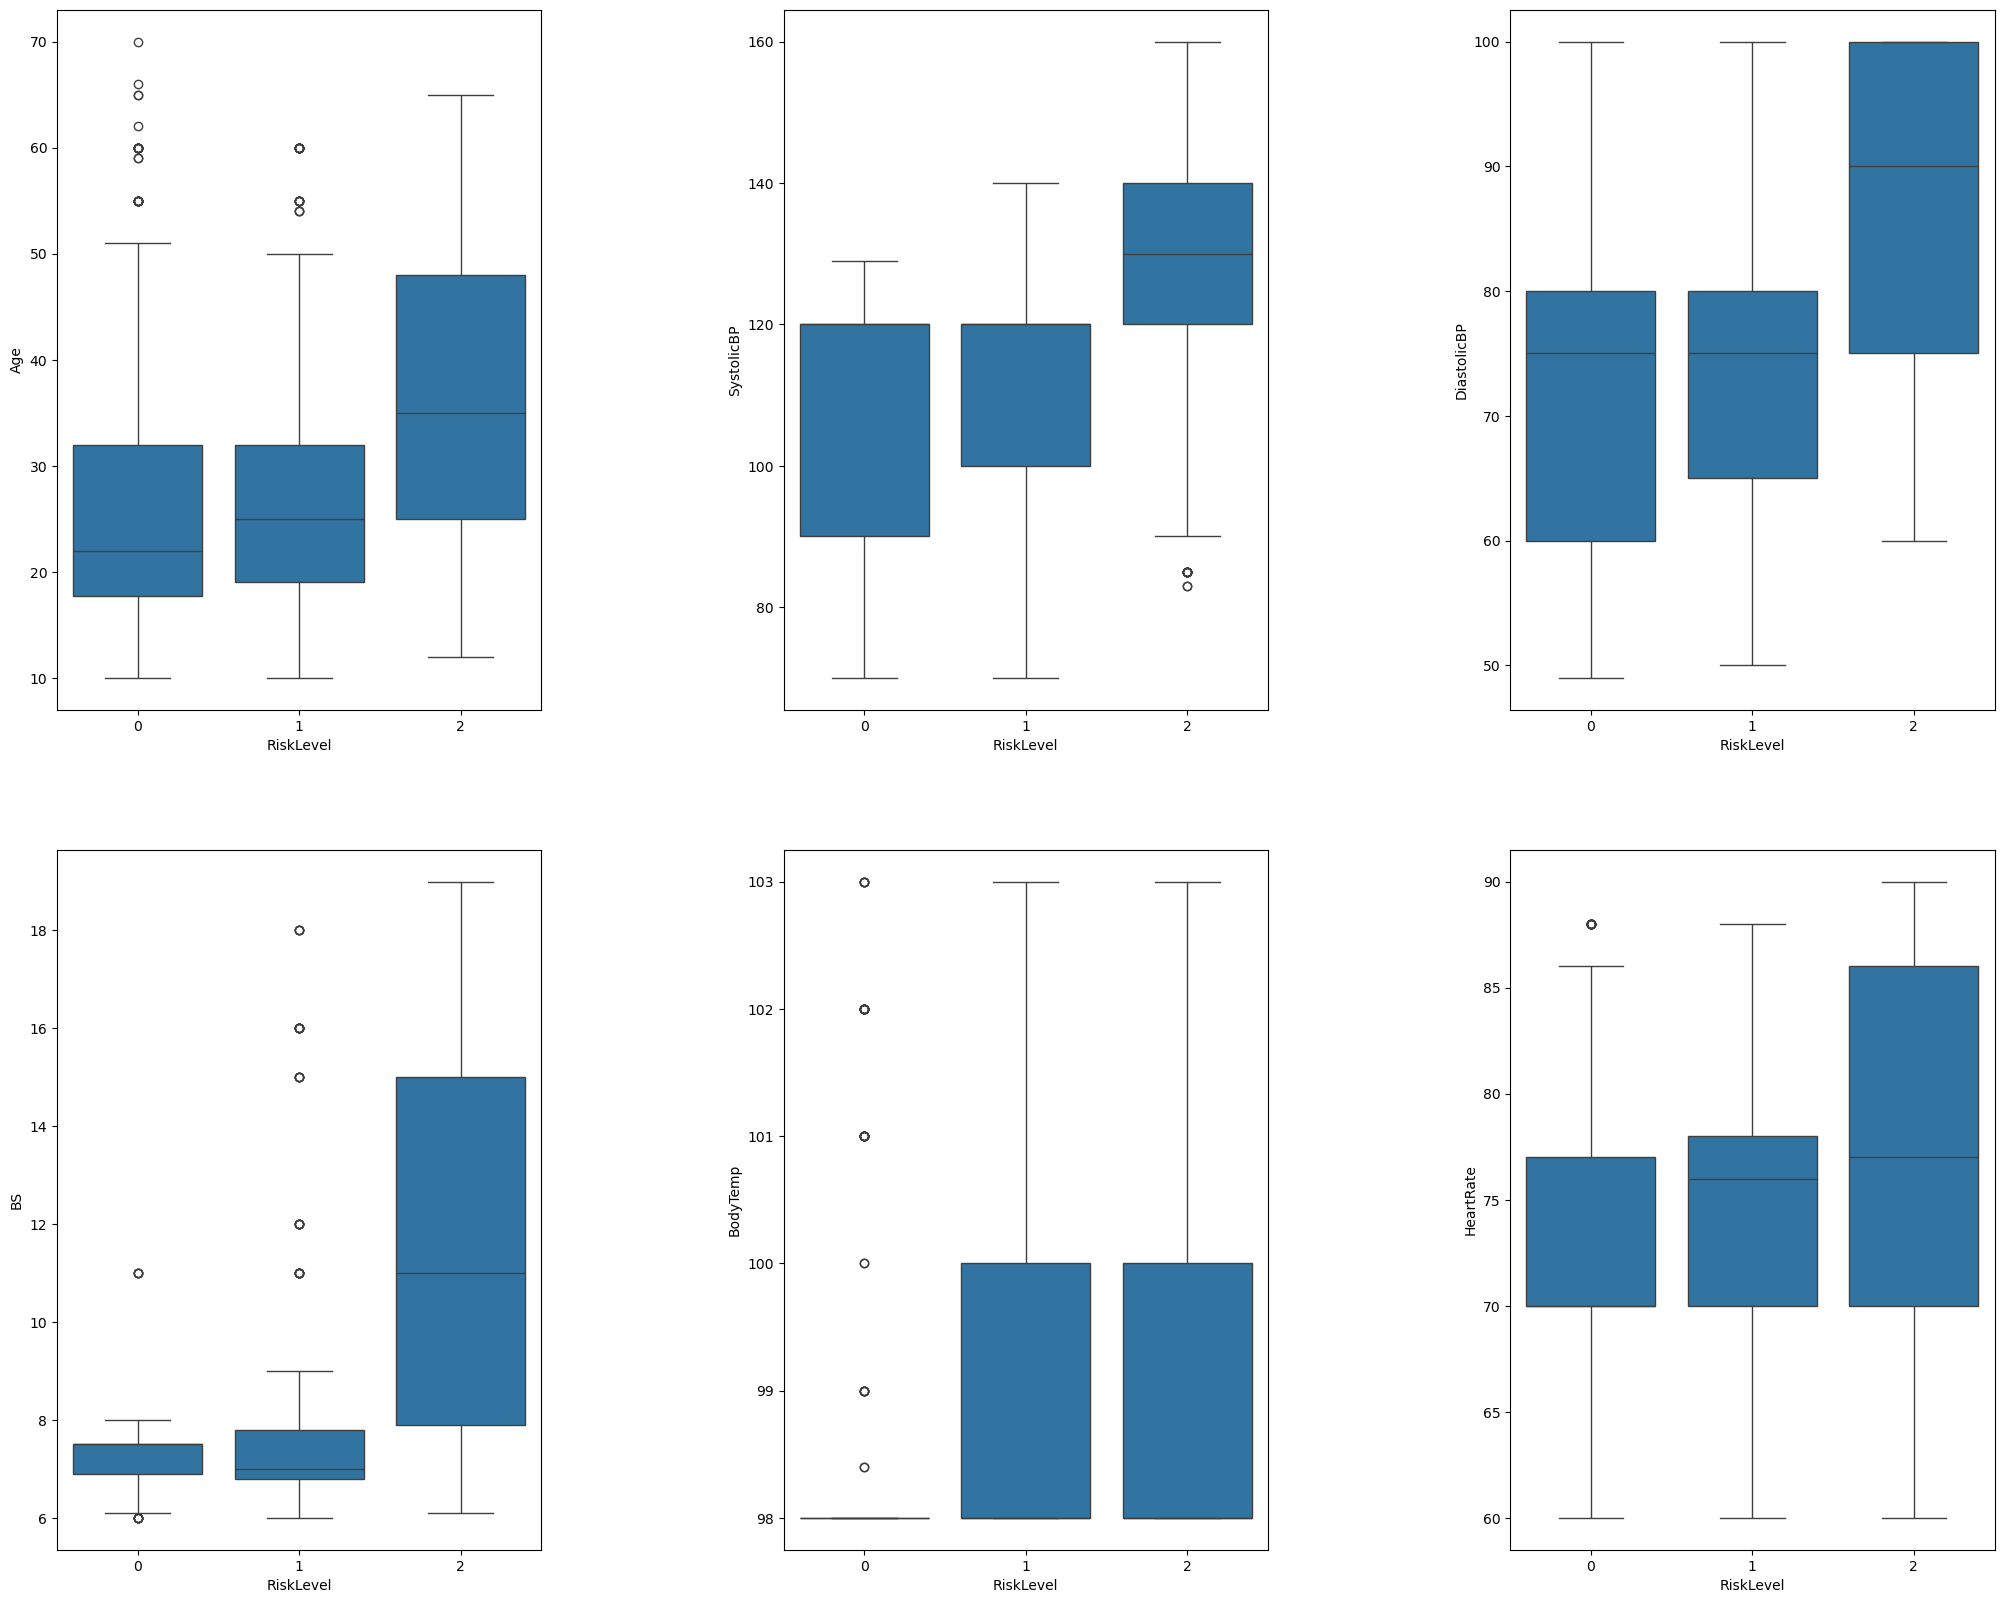

In [102]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(25,20))
fig.subplots_adjust(hspace=.2, wspace=.5)
axes= axes.ravel()
for i, col in enumerate(risk_df_dropHR.columns[:-1]):
    _ = sns.boxplot(y=col, x='RiskLevel', data=risk_df_dropHR, ax=axes[i])

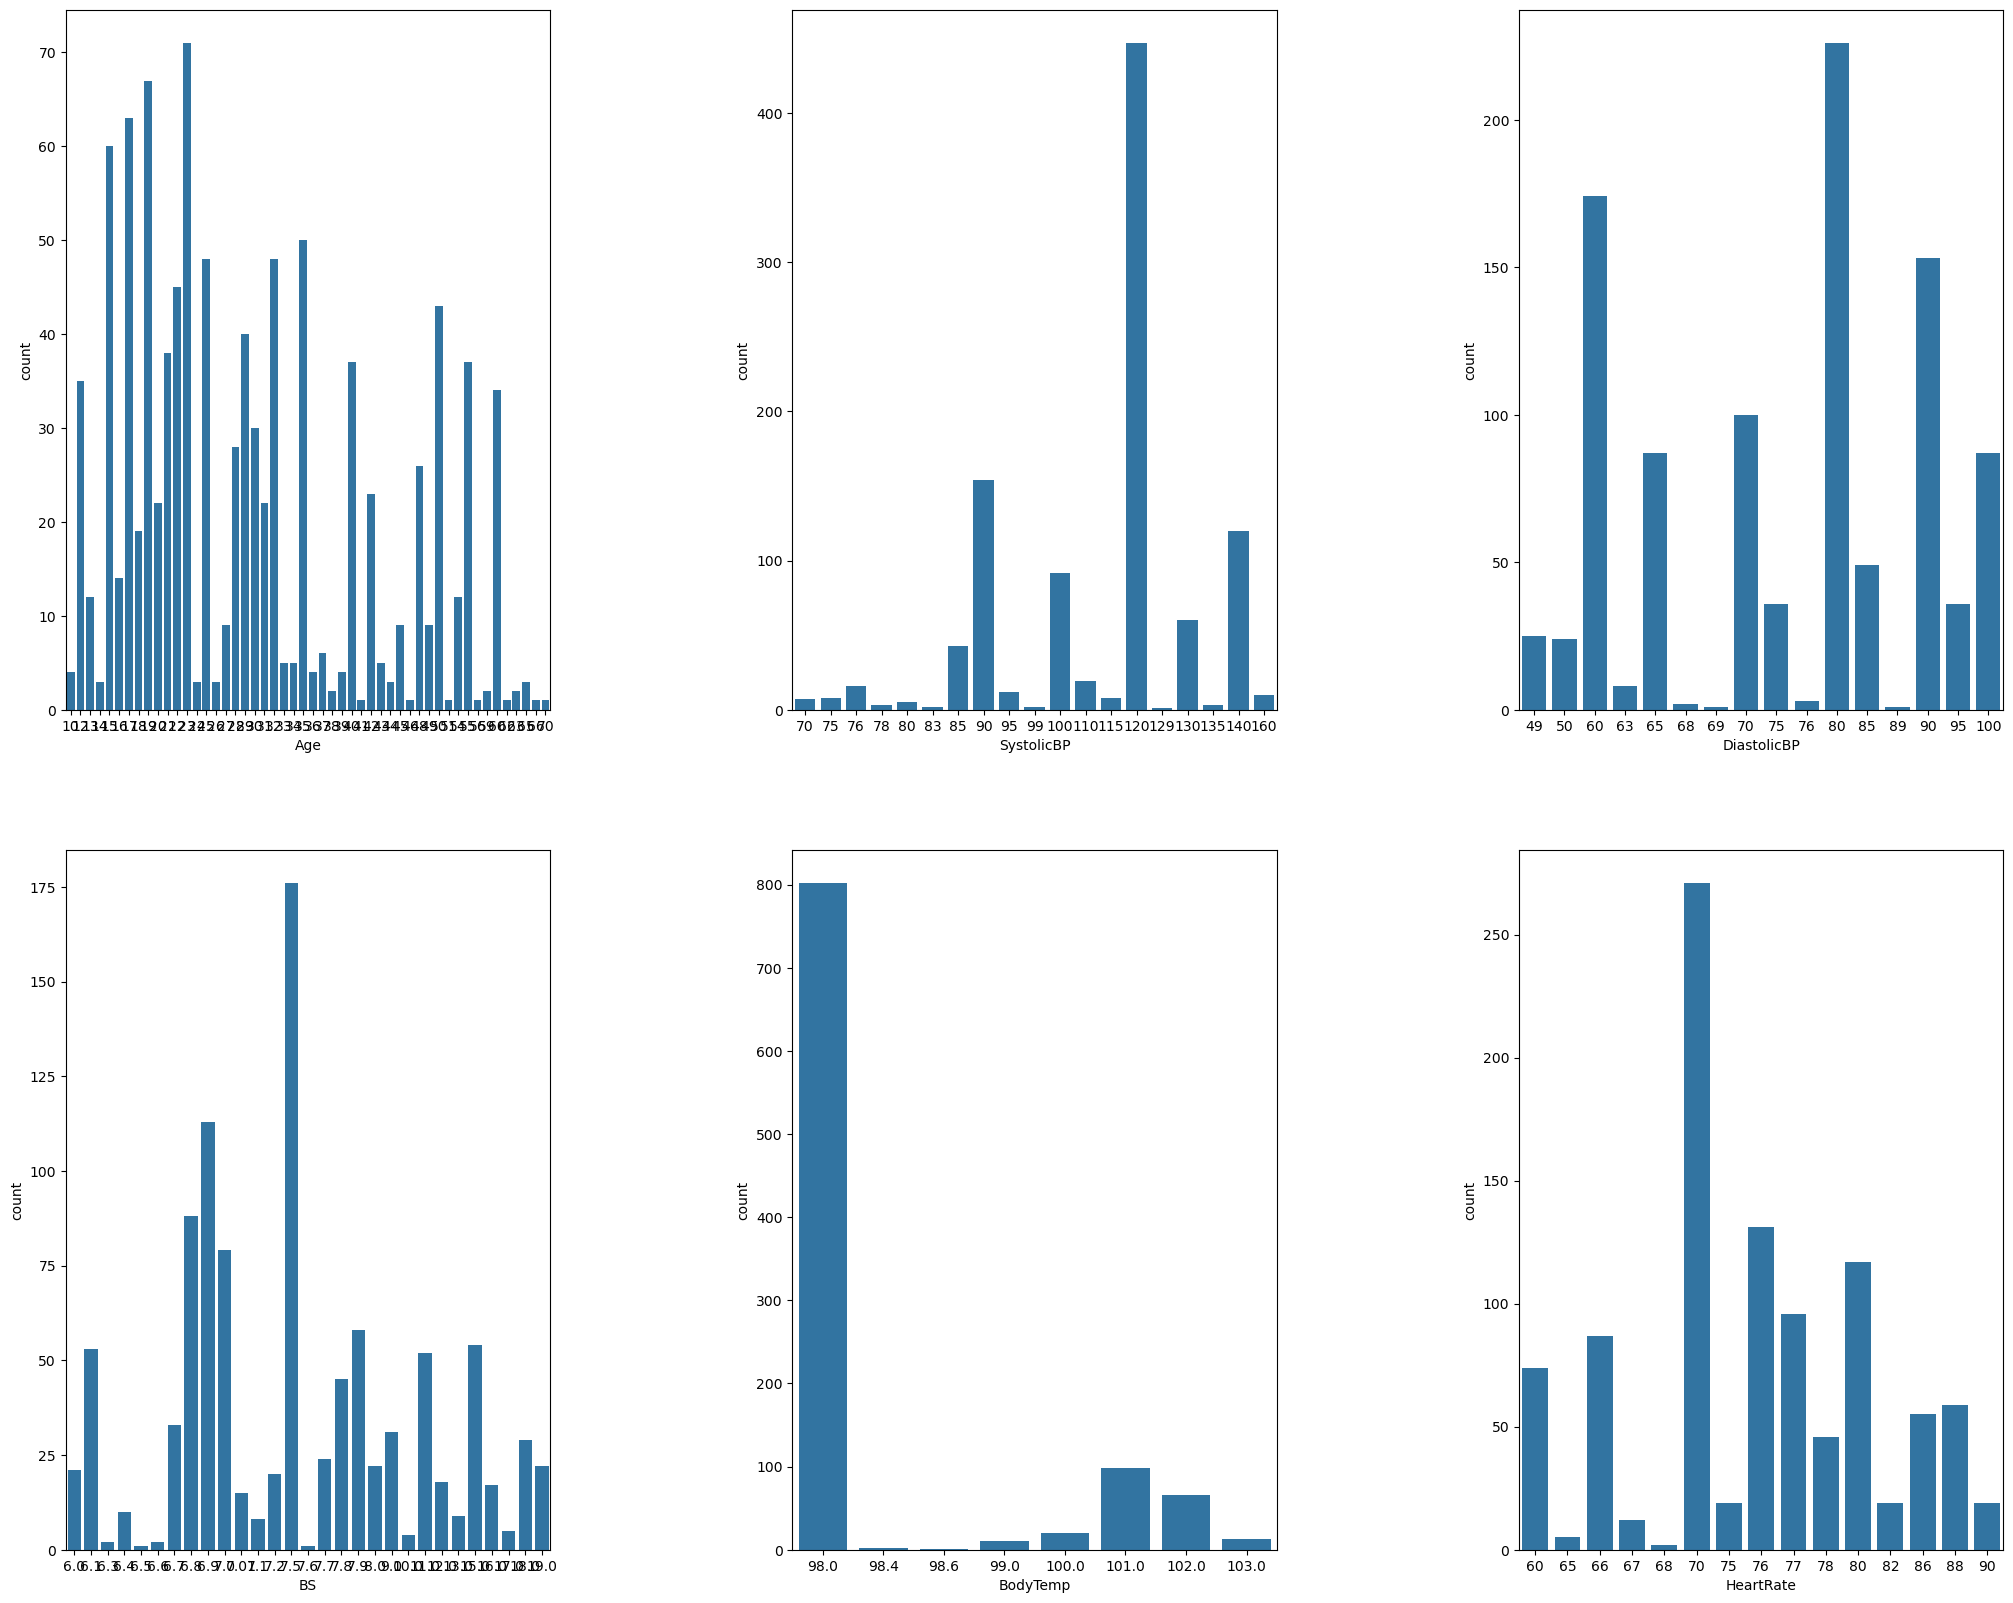

In [103]:
#counts
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(25,20))
fig.subplots_adjust(hspace=.2, wspace=.5)
axes= axes.ravel()
i=0
for col in risk_df_dropHR.columns[:-1]:
    _ = sns.countplot(x=col, data=risk_df_dropHR, ax=axes[i])
    i+=1

In [104]:
risk_df_dropHR.duplicated().sum()
risk_df_dropdupe = risk_df_dropHR.drop(risk_df_dropHR[risk_df_dropHR.duplicated()].index)
risk_df_dropdupe.duplicated().sum()
risk_df_dropdupe.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


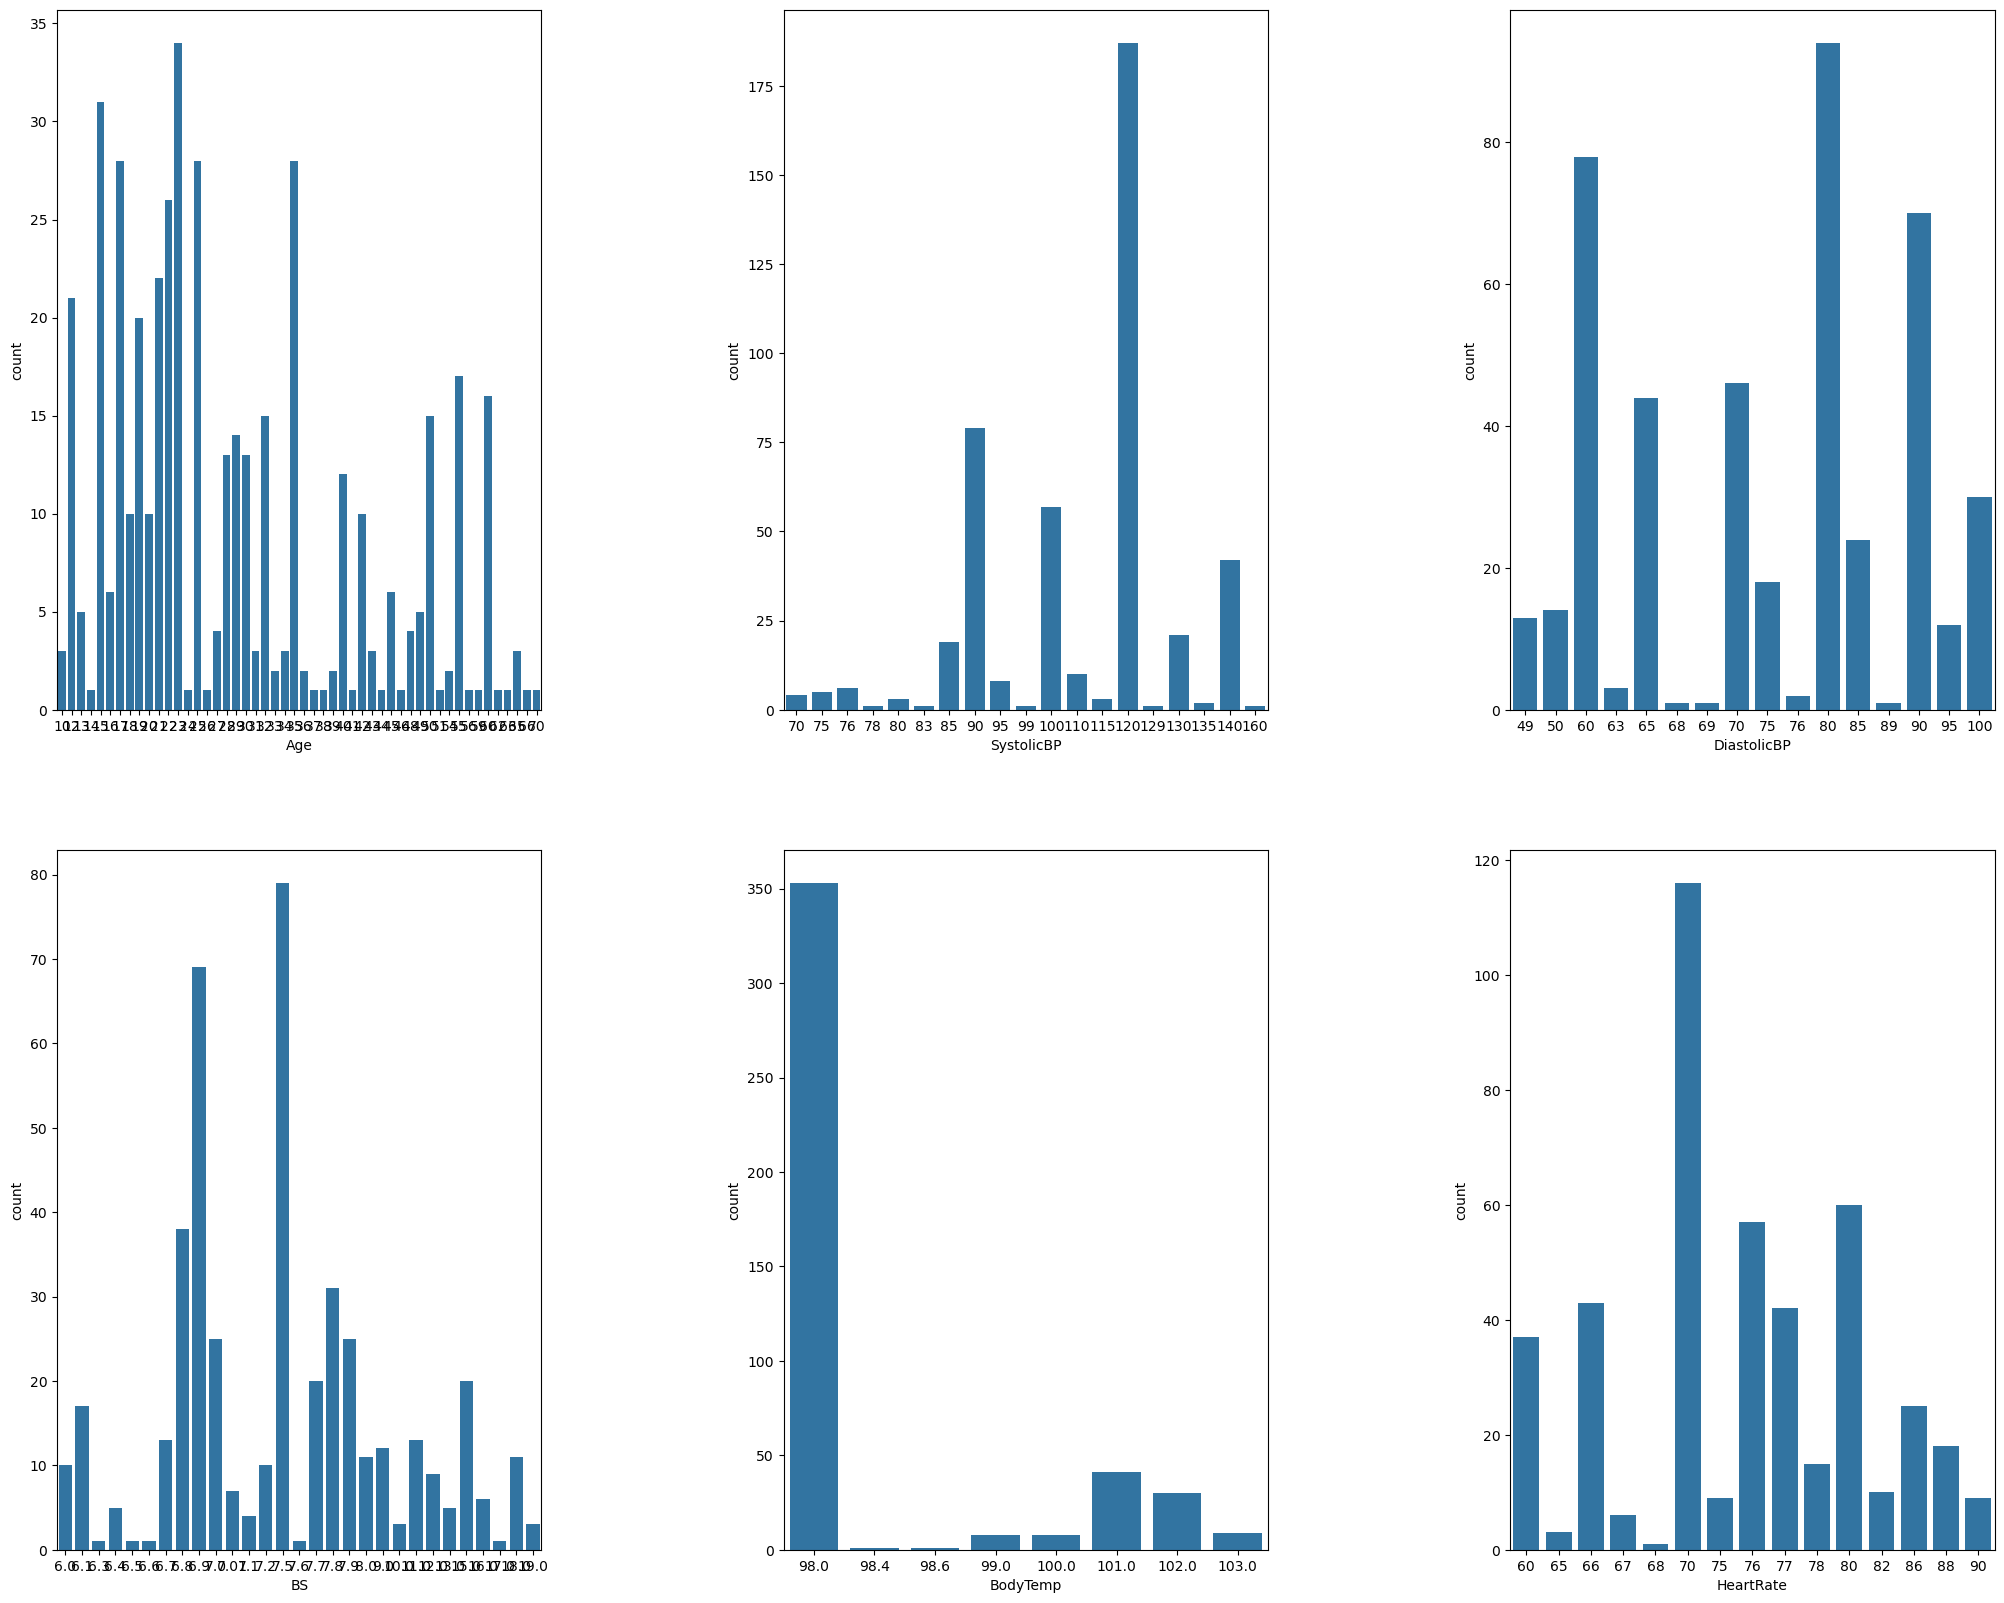

In [105]:
#counts
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(25,20))
fig.subplots_adjust(hspace=.2, wspace=.5)
axes= axes.ravel()
i=0
for col in risk_df_dropdupe.columns[:-1]:
    _ = sns.countplot(x=col, data=risk_df_dropdupe, ax=axes[i])
    i+=1

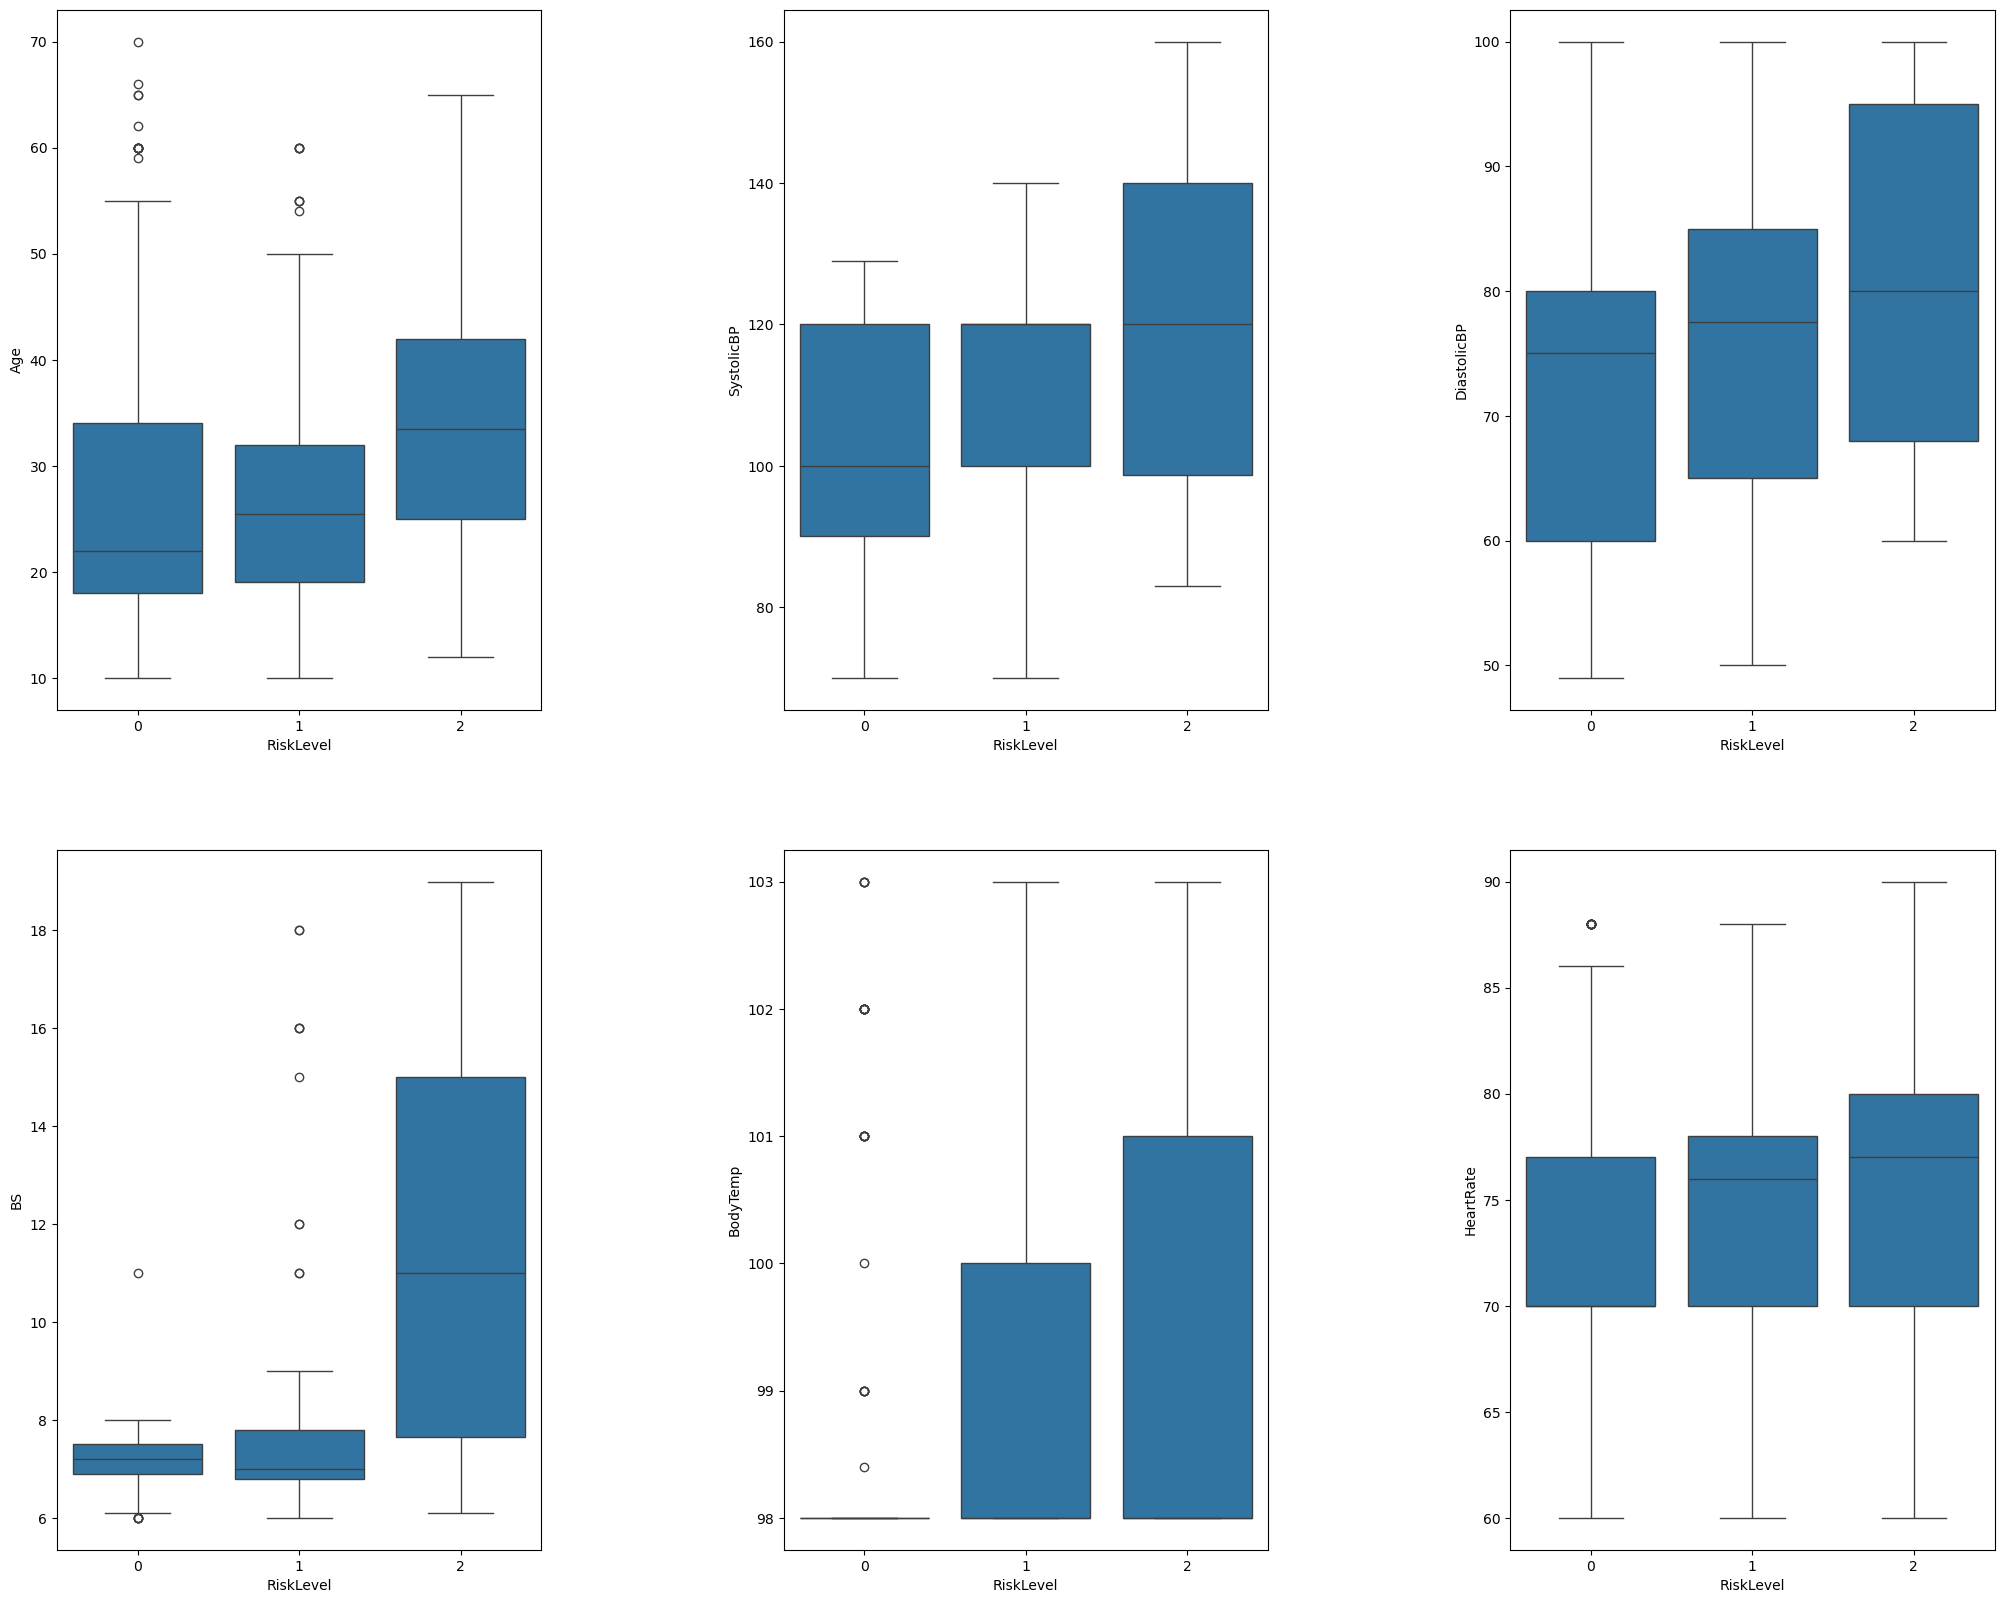

In [106]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(25,20))
fig.subplots_adjust(hspace=.2, wspace=.5)
axes= axes.ravel()
for i, col in enumerate(risk_df_dropdupe.columns[:-1]):
    _ = sns.boxplot(y=col, x='RiskLevel', data=risk_df_dropdupe, ax=axes[i])

<Axes: title={'center': 'Maternal Risk Correlation'}>

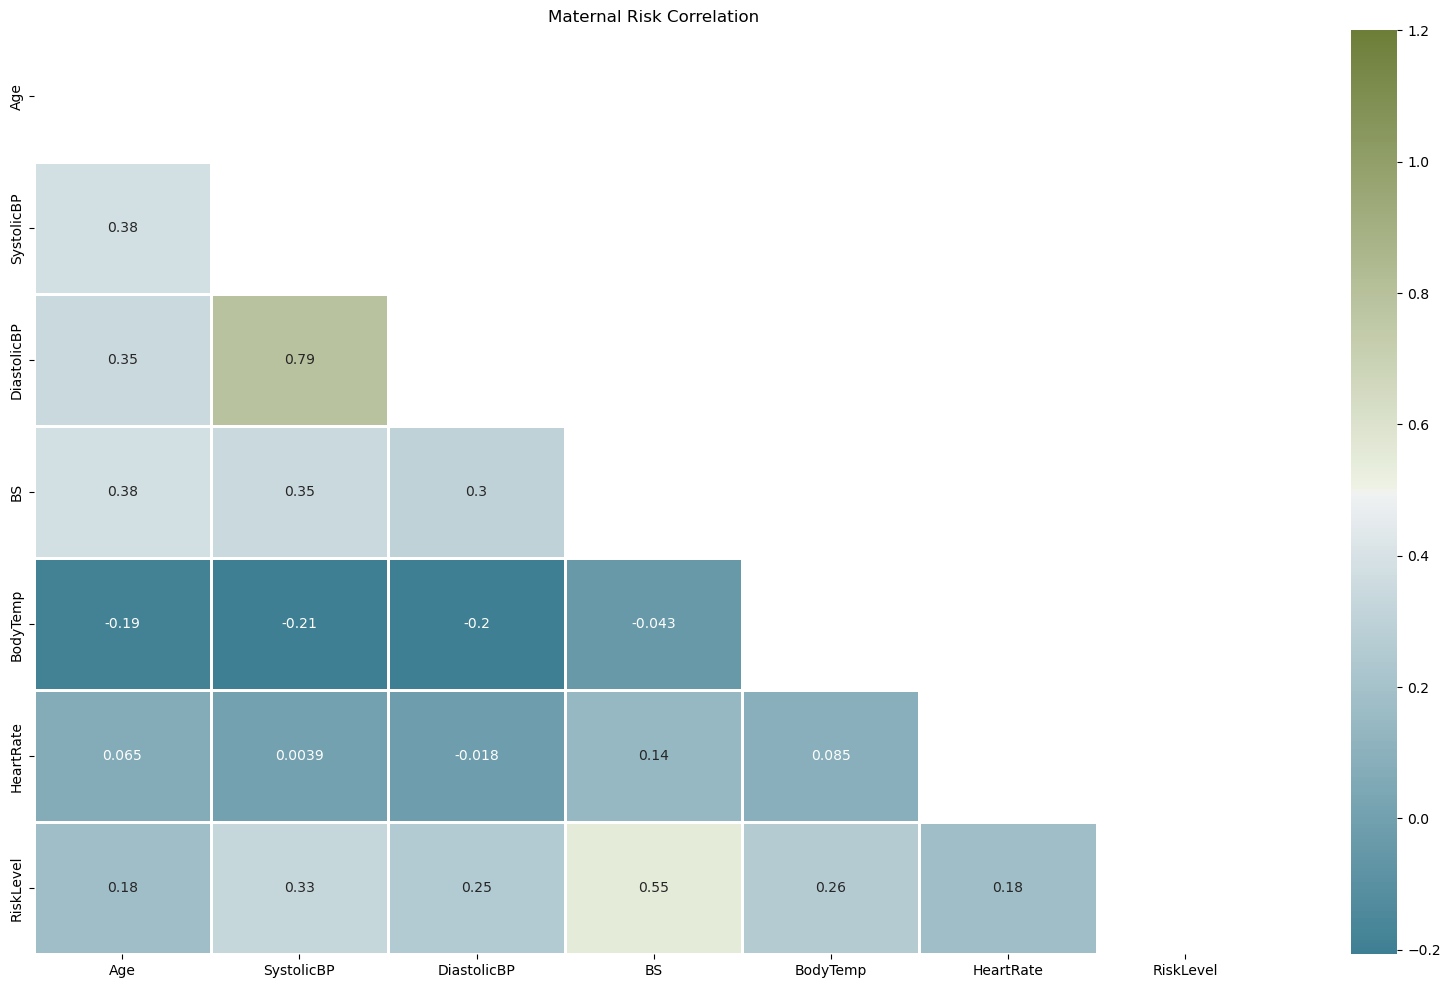

In [107]:
#correlation matrix
corrMatt = risk_df_dropdupe.corr(numeric_only=True)

#mask upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)]=True

#matplotlib figure
fig,ax = plt.subplots(figsize=(20,12))
plt.title('Maternal Risk Correlation')

#custom diverging colormap, integers determine the colours
cmap = sns.diverging_palette(220, 100,as_cmap=True)

#draw heatmap with mask
    #annot write the data in the cell
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=2)

### Cleaning Functions

In [108]:
def get_maternal_df():
    maternal_df = pd.read_csv('maternal_health_risk_data.csv', index_col=False)
    maternal_df['RiskLevel']=maternal_df['RiskLevel'].replace('high risk', 2)
    maternal_df['RiskLevel']=maternal_df['RiskLevel'].replace('mid risk', 1)
    maternal_df['RiskLevel']=maternal_df['RiskLevel'].replace('low risk', 0)

    maternal_df = remove_HR_outliers(maternal_df)
    return maternal_df

def remove_HR_outliers(df):
    data = df.describe()
    HR_IQR = data['HeartRate']['75%'] - data['HeartRate']['25%']
    HR_UQ = data['HeartRate']['75%'] + 1.5 * HR_IQR
    HR_LQ = data['HeartRate']['25%'] - 1.5 * HR_IQR
    
    return df.drop(df[(df['HeartRate'] < HR_LQ) | (df['HeartRate'] > HR_UQ)].index)

def get_maternal_features():
    df = get_maternal_df()
    df = df.drop('RiskLevel', axis=1)
    return df

def get_maternal_features_normalised():
    scaler = StandardScaler()
    features = get_maternal_features()
    return scaler.fit_transform(features)

def get_maternal_labels():
    df = get_maternal_df()
    return df['RiskLevel']

### Training Data

In [109]:
Xs = get_maternal_features_normalised()
y = get_maternal_labels()


Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=1)

C:\Users\domin\AppData\Local\Temp\ipykernel_17148\807085491.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  maternal_df['RiskLevel']=maternal_df['RiskLevel'].replace('low risk', 0)
C:\Users\domin\AppData\Local\Temp\ipykernel_17148\807085491.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  maternal_df['RiskLevel']=maternal_df['RiskLevel'].replace('low risk', 0)


### Logistic Regression

Best Hyperparameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.646938367795425
Logistic Regression Cross-Validation Accuracy Scores: [0.64039409 0.65517241 0.69306931 0.63366337 0.65841584]
Logistic Regression Average Cross-Validation Accuracy: 0.6561430034629079
              precision    recall  f1-score   support

           0       0.66      0.88      0.75       121
           1       0.48      0.34      0.40        94
           2       0.77      0.66      0.71        89

    accuracy                           0.65       304
   macro avg       0.64      0.63      0.62       304
weighted avg       0.64      0.65      0.63       304



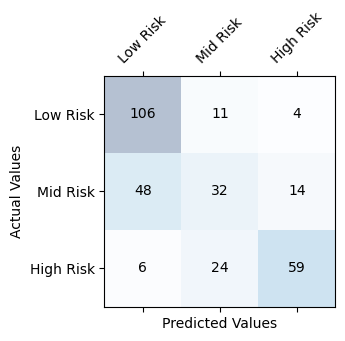

In [110]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2', 'l1'],   
    'solver': ['liblinear', 'saga'], 
    'max_iter': [100, 500, 1000]
}

log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(Xs_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

log_reg = LogisticRegression(C= 0.01, max_iter= 100, penalty= 'l2', solver= 'liblinear', random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, Xs, y, cv=kf, scoring='accuracy')
print("Logistic Regression Cross-Validation Accuracy Scores:", cv_scores)
print("Logistic Regression Average Cross-Validation Accuracy:", cv_scores.mean())

y_pred = log_reg.fit(Xs_train, y_train).predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
            s=cm[i, j],
            va='center', ha='center')
classes=["Low Risk","Mid Risk", "High Risk"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

### Decision Tree

Decision Tree Cross-Validation Accuracy Scores: [0.81280788 0.8226601  0.8019802  0.84653465 0.85148515]
Decision Tree Average Cross-Validation Accuracy: 0.8270935960591134
              precision    recall  f1-score   support

           0       0.86      0.79      0.83       121
           1       0.77      0.80      0.78        94
           2       0.87      0.93      0.90        89

    accuracy                           0.84       304
   macro avg       0.83      0.84      0.84       304
weighted avg       0.84      0.84      0.84       304



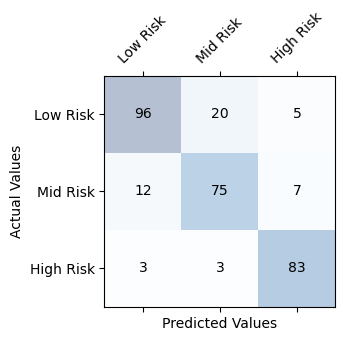

In [111]:
tree_clf = DecisionTreeClassifier(max_depth=18)
tree_kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(tree_clf, Xs, y, cv=tree_kf, scoring='accuracy')

print("Decision Tree Cross-Validation Accuracy Scores:", scores)
print("Decision Tree Average Cross-Validation Accuracy:", scores.mean())

y_pred = tree_clf.fit(Xs_train, y_train).predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
            s=cm[i, j],
            va='center', ha='center')
classes=["Low Risk","Mid Risk", "High Risk"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

### Random Forest

Random Forest Cross-Validation Accuracy Scores: [0.83743842 0.83743842 0.82673267 0.85148515 0.86633663]
Random Forest Average Cross-Validation Accuracy: 0.8438862605472369
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       121
           1       0.77      0.74      0.76        94
           2       0.88      0.94      0.91        89

    accuracy                           0.84       304
   macro avg       0.84      0.84      0.84       304
weighted avg       0.84      0.84      0.84       304



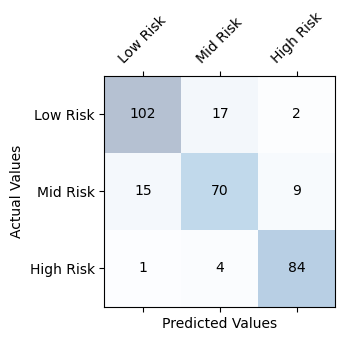

In [112]:
rnd_clf = RandomForestClassifier(max_depth=12)
rnd_kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(rnd_clf, Xs, y, cv=rnd_kf, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy Scores:", scores)
print("Random Forest Average Cross-Validation Accuracy:", scores.mean())

y_pred = rnd_clf.fit(Xs_train, y_train).predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
            s=cm[i, j],
            va='center', ha='center')
classes=["Low Risk","Mid Risk", "High Risk"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

### SVM

SVM Cross-Validation Accuracy Scores: [0.82758621 0.83743842 0.83663366 0.85148515 0.87128713]
SVM Average Cross-Validation Accuracy: 0.8448861142271863
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       121
           1       0.60      0.39      0.47        94
           2       0.78      0.83      0.80        89

    accuracy                           0.70       304
   macro avg       0.69      0.69      0.68       304
weighted avg       0.69      0.70      0.69       304



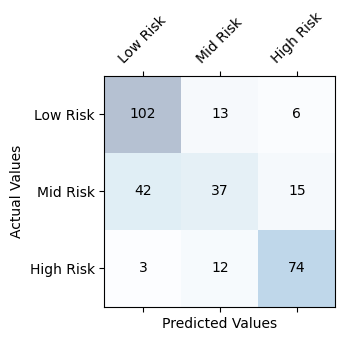

In [113]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold

pca = PCA(n_components=3)

svm_clf = SVC(C=1.0, gamma='auto', degree=3, kernel='rbf')
X_reduced = pca.fit_transform(Xs)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rnd_clf, Xs, y, cv=rnd_kf, scoring='accuracy')
print("SVM Cross-Validation Accuracy Scores:", scores)
print("SVM Average Cross-Validation Accuracy:", scores.mean())

y_pred = svm_clf.fit(Xs_train, y_train).predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
            s=cm[i, j],
            va='center', ha='center')
classes=["Low Risk","Mid Risk", "High Risk"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

### ANN

In [114]:
n_folds = 5

mlp_clf = MLPClassifier(hidden_layer_sizes=(200,100), activation='relu', 
                        solver='sgd', alpha=0.001, batch_size=32, 
                        learning_rate='constant', learning_rate_init=0.1, 
                        power_t=0.5, max_iter=10000, shuffle=True, 
                        random_state=None, tol=0.0001, verbose=False, 
                        momentum=0.8, 
                        nesterovs_momentum=True, 
                        validation_fraction=0.1, 
                        n_iter_no_change=10).fit(Xs_train, y_train)

scores = cross_val_score(mlp_clf, Xs, y, cv=n_folds)
print("MLP Cross-Validation Accuracy Scores:", scores)
print("MLP Average Cross-Validation Accuracy:", scores.mean())

MLP Cross-Validation Accuracy Scores: [0.75369458 0.71921182 0.78712871 0.76237624 0.78712871]
MLP Average Cross-Validation Accuracy: 0.7619080134614447


              precision    recall  f1-score   support

           0       0.79      0.45      0.57       121
           1       0.49      0.74      0.59        94
           2       0.83      0.85      0.84        89

    accuracy                           0.66       304
   macro avg       0.70      0.68      0.67       304
weighted avg       0.71      0.66      0.66       304



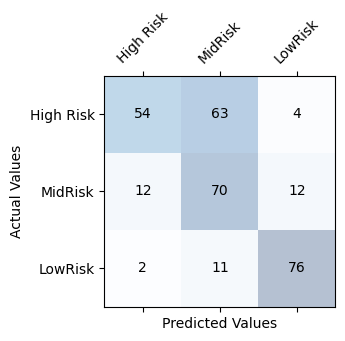

In [115]:
y_pred = mlp_clf.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred) 

# Plot confusion matrix
fig, ax = plt.subplots(figsize = (3,3))
ax.matshow(cm, cmap = plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
                s = cm[i,j],
                va='center', ha='center')
        
classes=["High Risk", "MidRisk", "LowRisk"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45) 
plt.yticks(tick_marks, classes) 
plt.xlabel('Predicted Values', ) 
plt.ylabel('Actual Values'); 
print(classification_report(y_test, y_pred)) 

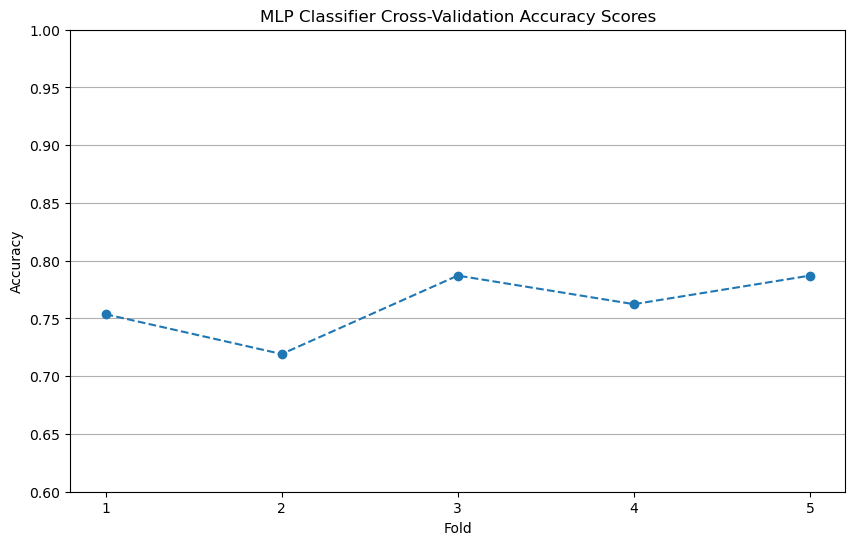

In [116]:
plt.figure(figsize=(10, 6))

folds = np.arange(1, n_folds + 1)
plt.plot(folds, scores, marker='o', linestyle='--')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Cross-Validation Accuracy Scores')

plt.xticks(folds) 
plt.ylim(0.6, 1)  
plt.grid(axis='y', linestyle='-')

plt.show()